# Hierarchical Partial Pooling for Repeated Binary Trials

- BaseBall Hits: The source of this notebook the following page.
    - https://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html
- Here I use numpyro instead of stan and R.

In [1]:
import sys
sys.version

'3.8.0 (default, Feb 25 2021, 22:10:10) \n[GCC 8.4.0]'

In [1]:
import argparse
import os

import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import logsumexp

import numpyro
import numpyro as npr
import numpyro.distributions as dist
from numpyro.examples.datasets import BASEBALL, load_dataset
from numpyro.infer import HMC, MCMC, NUTS, Predictive, log_likelihood
print(numpyro.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz
import pandas as pd
import numpy as np
# sns.set()
# # plt.style.use('dark_background')
# plt.style.use('seaborn-white')
# sns.set_theme()

plt.rcParams['figure.dpi'] = 100
# plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")

0.6.0


In [2]:
assert numpyro.__version__.startswith('0.6.0')
num_samples = 5000
num_warmup  = 1500
algo = 'NUTS'  # 'HMC', 'NUTS', 'SA'
num_chains = 1
numpyro.set_host_device_count(num_chains)

In [5]:
def gomcmc(model, data_dict, num_samples=10000):
    rng_key = jax.random.PRNGKey(0)
    # run MCMC
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=1)
    mcmc.run(rng_key, **data_dict)
    mcmc.print_summary(exclude_deterministic=False)
    return mcmc

In [6]:
def get_samples(mcmc):
    if isinstance(mcmc, dict):
        s = mcmc
    else:
        s = mcmc.get_samples()
    d = {}
    for k, v in s.items():
        if len(v.shape) == 2:
            for i in range(v.shape[1]):
                d[f'{k}_{i}'] = np.array(v[:,i])
        else: # len(v.shape) == 1
            d[k] = np.array(v)
    return d

# Data
- traint: at_bats, hits
- test: at_bats, hits
- The dataset separates the initial 45 at-bats statistics from the remaining season. 
- We use the hits data from the initial 45 at-bats to **estimate the batting average for each player**.
- We then use the remaining season's data to validate the predictions from our models.

In [7]:
_, fetch_train = load_dataset(BASEBALL, split='train', shuffle=False)
train, player_names = fetch_train()
_, fetch_test = load_dataset(BASEBALL, split='test', shuffle=False)
test, _ = fetch_test()
at_bats, hits = train[:, 0], train[:, 1]
season_at_bats, season_hits = test[:, 0], test[:, 1]
#
df = pd.DataFrame({'Player': player_names, 'AtBats': at_bats, 'Hits': hits, 
                   'RemainingAB': season_at_bats, 'RemainingHits': season_hits})
df['Player'] = df['Player'].astype('category')
df

,Player,AtBats,Hits,RemainingAB,RemainingHits
0,Roberto Clemente,45,18,412,145
1,Frank Robinson,45,17,471,144
2,Frank Howard,45,16,566,160
3,Jay Johnstone,45,15,320,76
4,Ken Berry,45,14,463,128
5,Jim Spencer,45,14,511,140
6,Don Kessinger,45,13,631,168
7,Luis Alvarado,45,12,183,41
8,Ron Santo,45,11,555,148
9,Ron Swaboda,45,11,245,57


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Player         18 non-null     category
 1   AtBats         18 non-null     int64   
 2   Hits           18 non-null     int64   
 3   RemainingAB    18 non-null     int64   
 4   RemainingHits  18 non-null     int64   
dtypes: category(1), int64(4)
memory usage: 1.4 KB


We will only need a few columns of the data; we will be using the remaining hits and at bats to evaluate the predictive inferences for the various models.

In [9]:
N = len(df)
K = df.AtBats
y = df.Hits
K_new = df.RemainingAB
y_new = df.RemainingHits

The data separates the outcome from the initial 45 at-bats from the rest of the season. After running this code, 
- `N` is the number of items (players). 
- Then for each item `n`, `K[n]` is the number of initial trials (at-bats), 
- `y[n]` is the number of initial successes (hits), 
- `K_new[n]` is the remaining number of trials (remaining at-bats), and 
- `y_new[n]` is the number of successes in the remaining trials (remaining hits).

The remaining data can be used to evaluate the predictive performance of our models conditioned on the observed data. That is, we will “train” on the first 45 at bats and see how well our various models do at predicting the rest of the season.

# Pooling
- With `complete pooling`, each item is assumed to have the same chance of success. 
- With `no pooling`, each item is assumed to have a completely unrelated chance of success. 
- With `partial pooling`, each item is assumed to have a different chance of success, but the data for all of the observed items informs the estimates for each item.

- Partial pooling is typically accomplished through hierarchical models. 
- Hierarchical models directly model the population of items. 
    - The population mean and variance is important, but the two hierarchical models we consider (chance of success vs. log odds of success) provide rather differently shaped posteriors.
    - From a population model perspective, no pooling corresponds to infinite population variance, whereas complete pooling corresponds to zero population variance.


# Model 1: Complete Pooling

- The complete pooling model assumes a single parameter $\theta$ representing the chance of success for all items.

- Assuming each player’s at-bats are independent Bernoulli trials, the sampling distribution for each player’s number of hits $y_n$ is modeled as
$$
    p(y_n|ϕ) = \mathrm{Binomial}(y_n|K_n,ϕ) \quad\mbox{likelihood}
$$
- Assuming each player is independent leads to the complete data likelihood
$$
    p(y|ϕ) = \prod_{n=1}^N\mathrm{Binomial}(y_n|K_n,ϕ)
$$
- We will assume a uniform piror on ϕ, representing the chance of success:
$$
    p(ϕ) = \mathrm{Uniform}(ϕ|0,1) = 1 \mbox{ for } ϕ \in [0,1]
$$

In [10]:
def cp_model(atbats, hits=None):
    theta = npr.sample('theta', dist.Uniform(0, 1))
    
    size_y = len(atbats)
    with npr.plate(f'N={size_y}', size=size_y):
        y = npr.sample('y', dist.Binomial(total_count=atbats, probs=theta), obs=hits)

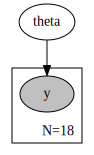

In [11]:
numpyro.render_model(cp_model, model_args=(df.Hits.values, df.AtBats.values))

In [12]:
data = dict(hits=df.Hits.values, atbats=df.AtBats.values)
mcmcfit_cp = gomcmc(cp_model, data)

sample: 100%|██████████| 11000/11000 [00:10<00:00, 1067.08it/s, 7 steps of size 1.05e+00. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.27      0.02      0.27      0.24      0.29   3384.01      1.00

Number of divergences: 0


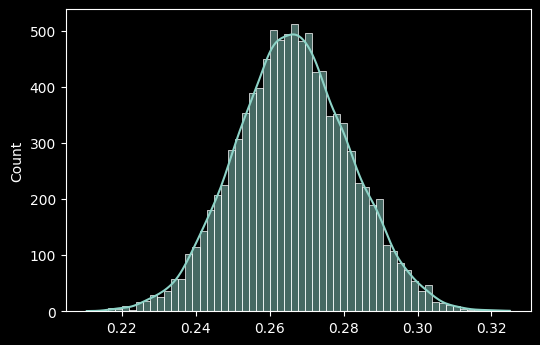

In [13]:
sns.histplot(mcmcfit_cp.get_samples()['theta'], kde=True);

In [14]:
hdi = arviz.hdi(np.array(mcmcfit_cp.get_samples()['theta']))
hdi, hdi[1] - hdi[0]

(array([0.23710737, 0.29485205], dtype=float32), 0.05774468)

- The result is a posterior mean for θ of 0.27 with an 90% central posterior interval of (0.24,0.29). With more data, such as from more players or from the rest of the season, the posterior approaches a delta function around the maximum likelihood estimate and the posterior interval around the centeral posterior intervals will shrink. 
- Nevertheless, even if we know a player’s chance of success exactly, there is a large amount of uncertainty in running K binary trials with that chance of success; using a binomial model fundamentally bounds our prediction accuracy.

- Although this model will be a good baseline for comparison, we have good reason to believe from a large amount of prior data (players with as many as 10,000 trials) that **it is very unlikely that all players have the same chance of success.**

# Model 2: No Pooling

- A model with **no pooling** involves a separate chance-of-success parameters  $\theta_n\in[0,1]$ for each item $n$.
- The prior on each $\theta_n$ is uniform
$$
    p(\theta_n) = \mathrm{Uniform}(\theta_n|0,1)
$$
- and the $\theta_n$ are assumed to be independent,
$$
    p(\theta) = \prod_{n=1}^N\mathrm{Uniform}(\theta_n|0,1)
$$

- Assuming each player’s at-bats are independent Bernoulli trials, the sampling distribution for each player’s number of hits $y_n$ is modeled as
$$
    p(y_n|\theta_n) = \mathrm{Binomial}(y_n|K_n, \theta_n) \quad\mbox{likelihood}
$$
- Assuming $y_n$ are independent (conditioned on $\theta$) leads to the total data likelihood
$$
    p(y|\theta) = \prod_{n=1}^N\mathrm{Binomial}(y_n|K_n,ϕ)
$$


In [15]:
def np_model(atbats, hits=None):    
    size_y = len(hits) if hits is not None else 1
    with npr.plate(f'N={size_y}', size=size_y):
        theta = npr.sample('theta', dist.Uniform(0, 1))
        y = npr.sample('y', dist.Binomial(total_count=atbats, probs=theta), obs=hits)

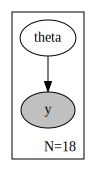

In [16]:
numpyro.render_model(np_model, model_args=(df.Hits.values, df.AtBats.values))

In [17]:
data = dict(hits=df.Hits.values, atbats=df.AtBats.values)
mcmcfit_np = gomcmc(np_model, data)

sample: 100%|██████████| 11000/11000 [00:11<00:00, 998.70it/s, 7 steps of size 5.46e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.40      0.07      0.40      0.29      0.52  19759.92      1.00
  theta[1]      0.38      0.07      0.38      0.27      0.50  23342.60      1.00
  theta[2]      0.36      0.07      0.36      0.25      0.48  23011.60      1.00
  theta[3]      0.34      0.07      0.34      0.23      0.45  22315.64      1.00
  theta[4]      0.32      0.07      0.32      0.21      0.43  20945.54      1.00
  theta[5]      0.32      0.07      0.32      0.21      0.43  22120.39      1.00
  theta[6]      0.30      0.07      0.29      0.18      0.40  23262.30      1.00
  theta[7]      0.28      0.06      0.27      0.17      0.38  21588.50      1.00
  theta[8]      0.26      0.06      0.25      0.16      0.36  21160.15      1.00
  theta[9]      0.26      0.06      0.25      0.15      0.36  21022.88      1.00
 theta[10]      0.23      0.06      0.23      0.13      0.33  23021.81      1.00
 theta[11]      0.23      0

In [18]:
hdi = arviz.hdi(np.array(mcmcfit_np.get_samples()['theta'][:,0]))
hdi, hdi[1] - hdi[0]

(array([0.2736489, 0.5375167], dtype=float32), 0.26386783)

## Appreciation
- Now there is a separate line for each item’s estimated $θ_n$. 
- The posterior mode is the maximum likelihood estimate, but that requires running an optimizer to find; the posterior mean and median will be reasonably close to the posterior mode despite the skewness (the posterior can be shown analytically to be a Beta distribution).
- Each std and 90% interval is much wider than the estimated interval for the population in the complete pooling model
    - std is in [0.05, 0.07] whereas std = 0.02 for complete pooling model
    - HDI is very much larger than that of the complete pooling model.
    - this is to be expected—there are only 45 data items for each parameter here as opposed to 810 in the complete pooling case. 
    - If the items each had different numbers of trials, the intervals would also vary based on size.

- As the estimated chance of success goes up toward 0.5, the 80% intervals gets wider. This is to be expected for chance of success parameters, because 
    1. the number of samples is smaller now, and 
    2. the standard deviation of a random variable distributed as Binomial(K,θ) is 
$$
    std = \sqrt{\frac{\theta (1 - \theta)}{K}}
$$

- The **no-pooling** model provides better MCMC mixing than the complete pooling model as indicated by the effective sample size and convergence diagnostics $\hat R$; 
    - although not in and of itself meaningful, it is often the case that badly misspecified models provide difficult computation (a result Andrew Gelman has dubbed “The Folk Theorem”).

- Based on our existing knowledge of baseball, the no-pooling model is almost certainly 
    1. overestimating the high abilities and 
    2. underestimating lower abilities 
    - Ted Williams, 30 years prior to the year this data was collected, was the last player with a 40% observed success rate over a season, whereas 20% is too low for all but a few rare defensive specialists.

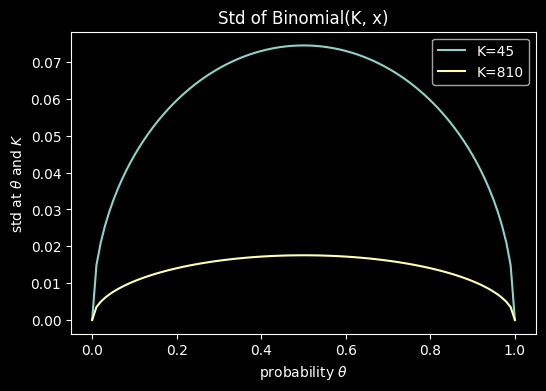

In [19]:
# std of Binomial(K, p) for two Ks.
K = 45
x = np.linspace(0, 1, 100)
plt.plot(x, np.sqrt(x*(1-x)/K), label=f'K={K}');
K = 810
plt.plot(x, np.sqrt(x*(1-x)/K), label=f'K={K}');
plt.title('Std of Binomial(K, x)'); 
plt.xlabel('probability $\\theta$');
plt.ylabel('std at $\\theta$ and $K$')
plt.legend();

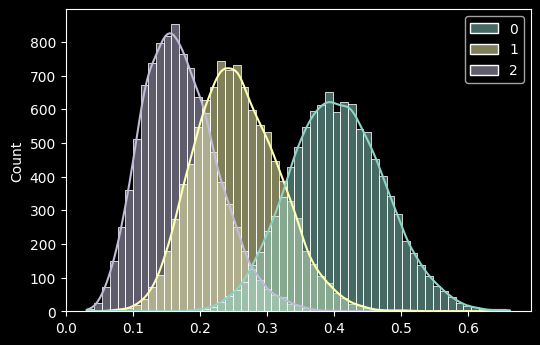

In [20]:
sns.histplot(mcmcfit_np.get_samples()['theta'][:,[0, 8, 17]], kde=True);

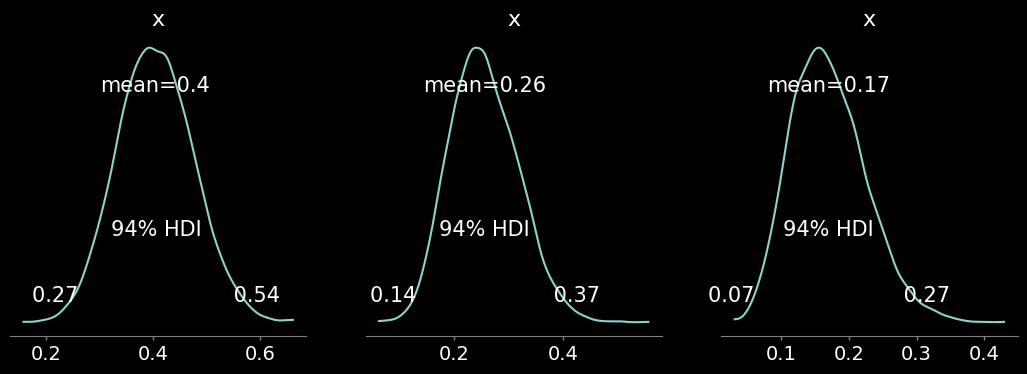

In [21]:
import arviz
trace = get_samples(mcmcfit_np.get_samples())
var = [0, 8, 17]
nplots = len(var)
fig, axes = plt.subplots(1, nplots, figsize=(13,4))
for i in range(nplots):
    arviz.plot_posterior(trace[f'theta_{var[i]}'], ax=axes[i]);

# Model 3: Partial Pooling (Chance of Success)

- Complete pooling provides estimated abilities that are too narrowly distributed for the items and removes any chance of modeling population variation. Estimating each chance of success separately without any pooling provides estimated abilities that are too broadly distributed for the items and hence too variable. Clearly some amount of pooling between these two extremes is called for. But how much?

- A **hierarchical model** treats the players as belonging to a population of players. The properties of this population will be estimated along with player abilities, implicitly controlling the amount of pooling that is applied. The more variable the (estimate of the) population, the less pooling is applied.

- Mathematically, the hierarchical model places a prior on the abilities with parameters that are themselves estimated. In this case, we will assume a beta distribution as the prior as it is scaled to values in $[0,1]$,
$$
p(\theta_n|\alpha, \beta) = \mathrm{Beta}(\theta_n|\alpha, \beta),
$$
where $α,β>0$ are the parameters of the prior. 

- The beta distribution is the conjugate prior for the binomial, meaning that the posterior is known to be a beta distribution. This also allows us to interpret the prior’s parameters as prior data, with $α−1$ being the prior number of successes and $β−1$ being the prior number of failures, and $α=β=1$ corresponding to no prior observations and thus a uniform distribution. Each $θ_n$ will be modeled as conditionally independent given the prior parameters, so that the complete prior is

$$
p(\theta|\alpha, \beta)=\prod_{n=1}^{N}\mathrm{Beta}(\theta_n|\alpha, \beta)
$$

- The parameters α and β are themselves given priors (sometimes called hyperpriors). 
- Rather than parameterize α and β directly, we will instead put priors on $ϕ∈[0,1]$ and $κ>0$, and then define $$α=κϕ \quad\quad β=κ(1−ϕ)$$

- This reparameterization is convenient, because
    - $ϕ=α/(α+β)$ is the mean of a variable distributed as $\mathrm{Beta}(α,β)$, and
    - $κ=α+β$ is the prior count (α+β-2) plus two (roughly inversely related to the variance).

- We will follow Gelman et al. (2013, Chapter 5) in providing a prior that factors into a uniform prior on ϕ,
$$
p(ϕ)=\mathrm{Uniform}(ϕ|0,1),
$$
and a Pareto prior on κ,
$$
p(\kappa)=\mathrm{Pareto}(κ|1,1.5) \propto κ^{−2.5}.
$$
with the restriction κ>1. 
    - In general, for functions f and g, we write f(x)∝g(x) if there is some constant c such that f(x)=cg(x). 
    - The first argument to the Pareto distribution is a bound ϵ>0, which in turn requires the outcome κ>ϵ; this is required so that the distribution can be normalized to integrate to 1 over its support. 
    - The value ϵ=1 is a conservative choice for this problem as we expect in the posterior, κ will be much greater than 1.

In [22]:
def pp_model(atbats, hits=None):
    kappa = numpyro.sample('kappa', dist.Pareto(1, 1.5))  # hyperprior, concentration
    phi   = numpyro.sample('phi', dist.Uniform())  # hyper, mean 
    a = kappa * phi
    b = (1 - phi) * kappa
    with numpyro.plate(f'N={len(atbats)}', size=len(atbats)):
        theta = numpyro.sample('theta', dist.Beta(a, b))
        #
        y = numpyro.sample('y', 
                           dist.Binomial(total_count=atbats, probs=theta), 
                           obs=hits)

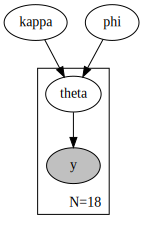

In [23]:
numpyro.render_model(pp_model, model_args=(df.Hits.values, df.AtBats.values))

In [24]:
data = dict(atbats=df.AtBats.values, hits=df.Hits.values)
mcmcfit_hier = gomcmc(pp_model, data)

sample: 100%|██████████| 11000/11000 [00:12<00:00, 867.47it/s, 15 steps of size 2.59e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     kappa    114.62    174.67     66.11      5.94    222.22    610.99      1.01
       phi      0.27      0.02      0.27      0.23      0.30   5375.53      1.00
  theta[0]      0.32      0.05      0.32      0.24      0.40   4330.01      1.00
  theta[1]      0.31      0.05      0.31      0.23      0.39   5398.68      1.00
  theta[2]      0.30      0.05      0.30      0.23      0.38   5979.07      1.00
  theta[3]      0.29      0.05      0.29      0.22      0.37   7417.25      1.00
  theta[4]      0.29      0.04      0.28      0.21      0.36  10115.91      1.00
  theta[5]      0.29      0.05      0.28      0.21      0.36   9958.25      1.00
  theta[6]      0.28      0.04      0.27      0.20      0.35   9563.87      1.00
  theta[7]      0.27      0.04      0.27      0.20      0.34  12436.55      1.00
  theta[8]      0.26      0.04      0.26      0.19      0.33  10036.68      1.00
  theta[9]      0.26      0

In [25]:
s = mcmcfit_hier.get_samples()

In [26]:
at_bats.sum(), hits/at_bats

(810,
 array([0.4       , 0.37777778, 0.35555556, 0.33333333, 0.31111111,
        0.31111111, 0.28888889, 0.26666667, 0.24444444, 0.24444444,
        0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
        0.2       , 0.17777778, 0.15555556]))

In [27]:
np.array([25, 225]) / 45

array([0.55555556, 5.        ])

- Bemcmcfit_hier Beta prior is conjugate to the binomial likelihood, the amount of interpolation between the data and the prior in this particular case is easy to quantify. The data consists of K observations, whereas the prior will be weighted as if it were κ−2 observations (specifically ϕκ−1 prior successes and (1−ϕ)κ−1 prior failures).

- The parameter κ is not well determined by the combination of data and Pareto prior, with a posterior 80% interval of roughly (25,225). 
    - By the informal discussion above, κ∈(25,225) ranges from weighting the data 2:1 relative to the prior to weighting it 1:5. 
    - The wide posterior interval for κ arises because the exact variance in the population is not well constrained by only 18 trials of size K=45. 
    - If there were more items (higher N) or even more trials per item (higher K), the posterior for κ would be more tightly constrained (see the exercises for an example).

- It is also evident from the posterior summary that the lower effective sample size for κ indicates it is not mixing as well as the other components of the model. 
    - This is to be expected with a centered hierarchical prior and low data counts. 
    - This is an example where a poorly constrained parameter leads to reduced computational efficiency (as reflected in the effective sample size). 
    - Such poor mixing is typical of centered parameterizations in hierarchical models (Betancourt and Girolami 2015). 
        - It is not immediately clear how to provide a non-centered analysis of the beta prior, because it isn’t supplied with a location/scale parameterization on the unconstrained scale. 
        - Instead, we consider an alternative parameterization in the next section.

- Figure 5.3 from (Gelman et al. 2014) plots the fitted values for ϕ and κ on the unconstrained scale, which is the space over which Stan is sampling. 
- The variable ϕ ∈ [0,1] is transformed to logit(ϕ)=log(ϕ/(1−ϕ)) and  κ ∈ (0,∞) is transformed to $\log κ$. We reproduce that figure here for our running example.

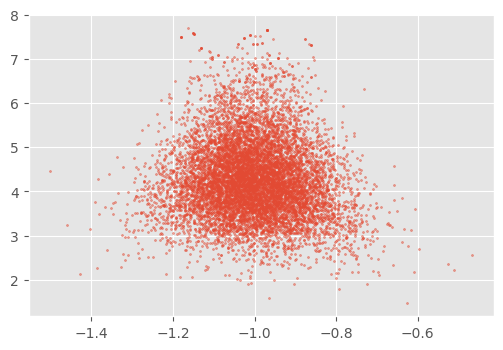

In [36]:
with plt.style.context('ggplot'): # black figures look strange
    plt.scatter(x=jax.scipy.special.logit(s['phi']),
               y=jnp.log(s['kappa']), alpha=.5, s=2);

- The (upside-down) funnel-like shape of the posterior is evident, with higher κ values corresponding to lower variance (hence the upside-downedness) and thus a narrower range of ϕ values. 
- This particular funnel-like posterior plot arises because when the population variation is large (i.e., κ is small), there is weak non-identifiability between the prior mean (ϕ) and the mean of the random effects (mean(θ)).

The root problem with the non-centered parameterization, though, is the relation between κ and the θ. For example, consider the following plot of $θ_0$ vs. κ.

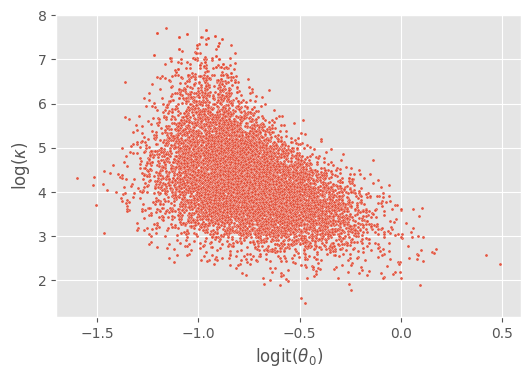

In [38]:
with plt.style.context('ggplot'): 

    ax = sns.scatterplot(x=jax.scipy.special.logit(s['theta'][:,0]),
                       y=jnp.log(s['kappa']), alpha=.9, s=5);
    ax.set(xlabel='logit($\\theta_0$)', ylabel='$\\log(\\kappa)$');

It is clear here that when κ is smaller, there is more latitude for $θ_1$ to move around. 
- This phenomenon was originally discussed by Neal (2003), is covered in the Stan manual (Stan Development Team 2015), 
- and is analyzed fors Hamiltonian Monte Carlo by Betancourt and Girolami (2015).
- Something related to Neal's Funnel.

**Stan:** We have unconstrained both θ1 (using logit−1) and κ (using log), rendering both on the unconstrained scale over which sampling is actually carried out in Stan. This helps in diagnosing problems with sampling that may not be as apparent on the constrained scale. All of the transforms used by Stan for constraints are detailed in the Stan manual (Stan Development Team 2015).

# Model 4: Partial Pooling (Log Odds)

The previous models all used a direct parameterization of the chance-of-success $θ_n∈[0,1]$. In this section, we consider an alternative parameterization in terms of the log-odds $α_n$, which are defined by the logit transform as

$$
    \alpha_n = \mathrm{logit}(\theta_n) = \log\frac{\theta_n}{1-\theta_n}
$$

- For example, $\theta_n=0.25$ corresponds to odds of $.25$ to $.75$ (equivalntly, 1 to 3, that is 1/3), or log-odds of $\log .25/.75 = -1.1$.

**Likelihood model**  now have logit as a so-called 'link' function:

$$
    p(y_n | K_n, \alpha_n) = \mathrm{Binomial}(y_n | K_n, \mathrm{logit}^{-1}(\alpha_n))
$$

- The inverse logit function is the logistic sigmoid from which logistic regression gets its name,

$$
    \mathrm{logit}^{-1}(\alpha_n) = \mathrm{expit}(\alpha_n) = \frac{1}{1+\exp(-\alpha_n)} = \theta_n
$$

- By construction, for any $α_n∈(−∞,∞)$, $\mathrm{logit}^{−1}(α_n)∈(0,1)$; 
    - the sigmoid converts arbitrary log odds (a real number) back to the chance-of-success scale. 
    - In practice, floating point calculations may underflow or overflow to 0 or 1, so in practice, we only know the result will be in $[0,1]$.
    - Modern PPLs including Stan, pymc3, and numpyro have a binomial probability function with a built-in logit link function, with which w can define the likelihood directly.

We use a simple normal hierarchical prior,

$$
    p(\alpha_n | \mu, \sigma) = \mathrm{Normal}(\alpha_n | \mu, \sigma)
    \quad\Leftrightarrow\quad
    \alpha_n \sim \mathrm{Normal}(\mu, \sigma)
$$

- Then one level up, we use a weakly informative hyperprior for $\mu$,

$$
    p(\mu) = \mathrm{Normal}(\mu| -1, 1) \quad\Leftrightarrow\quad \mu\sim \mathrm{Normal}(-1, 1)
$$
    
    - This places 95% of the prior probability for $\mu$ in the interval $(-3,1)$, which inverse-logit, i.e. sigmoid, transforms to the interval (0.05, 0.73) with a median 0.27 chance of success.
    - An even narrowr prior is actually motivated her from substantial basball knowledge.
    - This value should obviously be changed for other applications.
    
- The prior scale $\sigma > 0$ can be taken to be a truncatd normal (half normal):

$$
    p(\sigma) = \mathrm{HalfNormal}(\sigma| 0, 1)
$$

    which is a fairly broad prior, bing on the log-odds scale.

One of th major advantags of casting the problem in terms of log-odds is that its now easier to add in fixed effects and other multilevel effects, or even varying intercepts and slopes with multivariate priors (see Gelman and Hill (2007) for many such examples, all of which have been translated to Stan)

## Centered Parameterization

In [39]:
def logit_model_centered(atbats, hits=None):
    mu = numpyro.sample('mu', dist.Normal(-1., 1.))
    sigma = numpyro.sample('sigma', dist.HalfNormal(scale=1.))
    
    n_players = len(atbats)
    with numpyro.plate('n_players_plate', size=n_players):
        alpha = numpyro.sample('alpha', dist.Normal(mu, sigma))
        theta = numpyro.deterministic('theta', jax.scipy.special.expit(alpha))
        y = numpyro.sample('y', 
                           dist.Binomial(total_count=atbats, logits=alpha),
                           obs = hits)
#

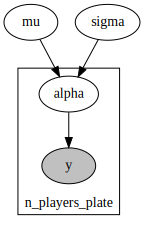

In [40]:
numpyro.render_model(logit_model_centered, model_args=(df.Hits.values, df.AtBats.values))

In [41]:
data = dict(atbats=df.AtBats.values, hits=df.Hits.values)
mcmcfit_logit_centered = gomcmc(logit_model_centered, data)

sample: 100%|██████████| 11000/11000 [00:12<00:00, 907.91it/s, 7 steps of size 1.95e-01. acc. prob=0.82]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.88      0.20     -0.91     -1.19     -0.55   1419.13      1.00
  alpha[1]     -0.90      0.20     -0.94     -1.19     -0.56   1870.50      1.00
  alpha[2]     -0.92      0.19     -0.95     -1.23     -0.62   1944.67      1.00
  alpha[3]     -0.95      0.18     -0.96     -1.22     -0.64   3046.67      1.00
  alpha[4]     -0.97      0.18     -0.98     -1.25     -0.67   3508.66      1.00
  alpha[5]     -0.97      0.18     -0.98     -1.25     -0.68   3380.03      1.00
  alpha[6]     -1.00      0.17     -1.00     -1.28     -0.71   4955.21      1.00
  alpha[7]     -1.02      0.17     -1.01     -1.31     -0.74   3742.59      1.00
  alpha[8]     -1.05      0.18     -1.04     -1.33     -0.76   3366.99      1.00
  alpha[9]     -1.05      0.18     -1.03     -1.36     -0.77   4179.29      1.00
 alpha[10]     -1.07      0.18     -1.05     -1.36     -0.79   2228.25      1.00
 alpha[11]     -1.07      0

With the centered parameterization and Stan’s defalt stepsize and target acceptance rate, there are many divergent transitions. 
- Even with 10,000 posterior draws, the effective sample size for the population scale $σ$ is in the low hundreds, with $\hat R>1.01$. 
- These results might be usable, but the high $\hat R$ and low effective sample size are sure signs the chains aren’t mixing well.

Warning: In cases where the chains are not mixing well, Stan’s effective sample size estimate will be much lower than that from packages such as Coda (Plummer 2006), which analyze each chain’s effective sample size separately (Gelman et al. 2013; Stan Development Team 2016). Thus it is important when comparing systems to use Stan’s more conservative effective sample size estimates; the other systems assume complete mixing in their effective sample size calculations and thus overestimate their performance when there is not good mixing.

In [42]:
s = mcmcfit_logit_centered.get_samples()

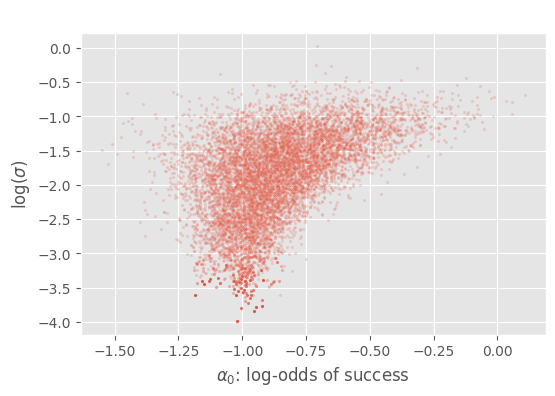

In [45]:
with plt.style.context('ggplot'): 

    ax = sns.scatterplot(x=s['alpha'][:,0],
                         y=jnp.log(s['sigma']), 
                         alpha=.2, s=5);
    ax.set(title='Centered Hierarchical Funnel Plot',
           xlabel='$\\alpha_0$: log-odds of success', 
           ylabel='$\\log(\\sigma)$');

The important feature of this plot is the reduced range possible for $α_0$ as $σ$ approaches zero (i.e., $\log σ$ approaches negative infinity). 
- Neal (2003) refers to the prior for the non-centered model as a “funnel”. 
- **With more data**, the funnel shape becomes less pronounced and this centered parameterization is actually more efficient than the non-centered parameterization we discuss in the next section (Betancourt and Girolami 2015).

## Non-Centered Parameterization

Betancourt and Girolami (2015) provide a detailed discussion of why the centered parameterization described in the previous section is challenging for MCMC methods to sample when there are small counts per group (here, the players are the groups and each has only 45 at bats observed).

- To mitigate the problem, they suggest moving to a non-centered parameterization, as has also been shown to be helpful for Gibbs and random-walk Metropolis samplers (Papaspiliopoulos et al. 2003). 
- This basically amounts to changing the parameterization over which sampling is done, taking now a standard unit normal prior for a new variable,

$$
    \alpha^\mathrm{std} \sim \mathrm{Normal}(0, 1)
$$

- We can then define our original $α$ as a derived quantity

$$
    α_n = μ + \sigma\cdot \alpha^\mathrm{std}_n
$$

- This decouples the sampling distribution for $α^\mathrm{std}$ from $μ$ and $σ$, greatly reducing their correlation in the posterior.

In [46]:
def logit_model_non_centered(atbats, hits=None):
    mu = numpyro.sample('mu', dist.Normal(-1., 1.))
    sigma = numpyro.sample('sigma', dist.HalfNormal(scale=1.))
    
    n_players = len(atbats)
    with numpyro.plate('n_players_plate', size=n_players):
        alpha_std = numpyro.sample('alpha_std', dist.Normal(0, 1))  # non-centered sampling
        alpha = numpyro.deterministic('alpha', mu + sigma * alpha_std)  # transform
        theta = numpyro.deterministic('theta', jax.scipy.special.expit(alpha))
        y = numpyro.sample('y', 
                           dist.Binomial(total_count=atbats, logits=alpha),
                           obs = hits)
#

In [47]:
data = dict(atbats=df.AtBats.values, hits=df.Hits.values)
mcmcfit_logit_nc = gomcmc(logit_model_non_centered, data)

sample: 100%|██████████| 11000/11000 [00:12<00:00, 888.22it/s, 15 steps of size 2.88e-01. acc. prob=0.89] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha[0]     -0.88      0.20     -0.92     -1.19     -0.56   6974.78      1.00
     alpha[1]     -0.91      0.19     -0.94     -1.20     -0.61   7856.97      1.00
     alpha[2]     -0.93      0.19     -0.95     -1.22     -0.63  10094.84      1.00
     alpha[3]     -0.95      0.18     -0.97     -1.23     -0.65  10489.99      1.00
     alpha[4]     -0.98      0.17     -0.99     -1.27     -0.71  14272.70      1.00
     alpha[5]     -0.98      0.17     -0.99     -1.26     -0.68  13029.02      1.00
     alpha[6]     -1.00      0.17     -1.00     -1.26     -0.71  13305.05      1.00
     alpha[7]     -1.02      0.17     -1.02     -1.32     -0.76  13023.18      1.00
     alpha[8]     -1.05      0.17     -1.04     -1.33     -0.78  13620.42      1.00
     alpha[9]     -1.05      0.17     -1.04     -1.33     -0.77  14410.41      1.00
    alpha[10]     -1.08      0.18     -1.06     -1.38     -0.81  11577.22  

- It is clear from the wide posteriors for the $θ_n$ that there is considerable uncertainty in the estimates of chance-of-success on an item-by-item basis. 
- With an 80% interval of (0.03,0.32), it is clear that the data is consistent with complete pooling (i.e., σ=0).

- Compared to the direct beta priors with uniform and Pareto hyperpriors shown in the first example, the normal prior on log odds exerts **more pull toward the population mean.**
    - The posterior means for θ ranged from 0.22 to 0.32 with the beta prior, but only range from 0.24 to 0.29 for the normal prior.
    - Furthermore, the posterior intervals for each values are **shrunk** compared to the beta prior. 
        - For example, Roberto Clemente (n=1), has an 80% central posterior interval of (0.25,0.35) in the logistic model, whereas he had an 80% posterior interval of (.26,.39) with a hierarchical beta prior.
        - Calculate for 90% interval for all other players.

In [48]:
s = mcmcfit_logit_nc.get_samples()

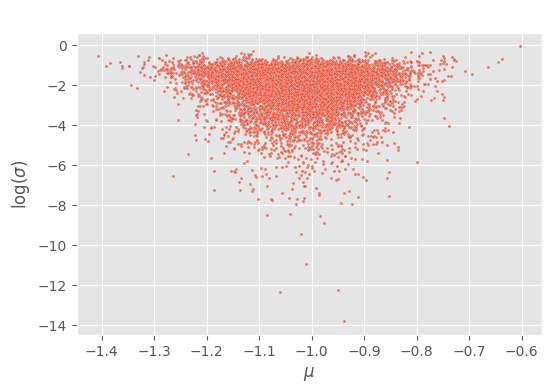

In [50]:
with plt.style.context('ggplot'): 

    ax = sns.scatterplot(x=s['mu'],
                         y=jnp.log(s['sigma']), 
                         alpha=.7, s=5);
    ax.set(title='Non-Centered Hierarchical Funnel Plot',
           xlabel='$\\mu$', 
           ylabel='$\\log(\\sigma)$');

As before, we see that the prior location $\mu$ and scale $\sigma$ are coupled in the posterior.


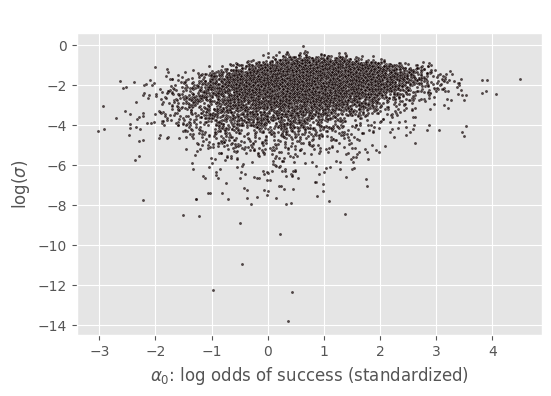

In [52]:
with plt.style.context('ggplot'): 

    ax = sns.scatterplot(x=s['alpha_std'][:,0],
                         y=jnp.log(s['sigma']), 
                         alpha=.7, s=5, color='#0f0202');
    ax.set(title='Non-Centered Hierarchical Funnel Plot',
           xlabel='$\\alpha_0$: log odds of success (standardized)', 
           ylabel='$\\log(\\sigma)$');

Compared to the earlier plot of $\log\kappa$ versus $logit(\theta_0)$ in the direct hierarcical model on chance of success, there is much less of a dependency between the variables.
- This can be seen because the variation is along the axes, not in a weak banana shape as in the first example.
- But it still has the long-tail problem as $\sigma$ approaches zero (and $\log\sigma$ becomes more negative).

---
# Observed vs. Estimated Chance of Success

Figure 5.4 from (Gelman et. al. 2013) plots the observed number of successes $y_n$ for the first $K_n$ trials versus the median and $80%$ intervals for the estimated chance-of-success parameters $\theta_n$ in the posterior. 

In [53]:
model_fits = [mcmcfit_cp, mcmcfit_np, mcmcfit_hier, mcmcfit_logit_nc]
model_names = ['complete pooling', 'no pooling', 'hier partial pooling', 'logit partial pooling']

In [54]:
def plot_median_interval(ax, fit, model_name, obs_rate, ylim=None, season_rate=None):
    #print(obs_rate)
    s = fit.get_samples()
    if season_rate is not None:
        rate = zip(obs_rate, season_rate)
    else:
        rate = obs_rate
    #
    for i, obsr in enumerate(rate):
        si = s['theta'][:,i] if len(s['theta'].shape) > 1 else s['theta']
        si = si.sort()
        median = jnp.quantile(si, q=.5)
        q1, q2 = jnp.quantile(si, q=.1), jnp.quantile(si, q=.9)
        if season_rate is not None:
            obsr, seasr = obsr  # 
            ax.scatter(x=obsr, y=seasr, marker='x', color='k')
        ax.errorbar(x=obsr, y=median, yerr=[[median-q1], [q2-median]], fmt='o-')
    xlim = ax.get_xlim() # y=x line
    ax.plot(xlim, xlim, '-', label='MLE line')
    pop_mean = obs_rate.mean()
    ax.plot(xlim, [pop_mean, pop_mean], 'r-', label='Pop. mean')
    if ylim is not None: ax.set(ylim=ylim)
    ax.legend(loc='upper left')
    ax.set(title=model_name)

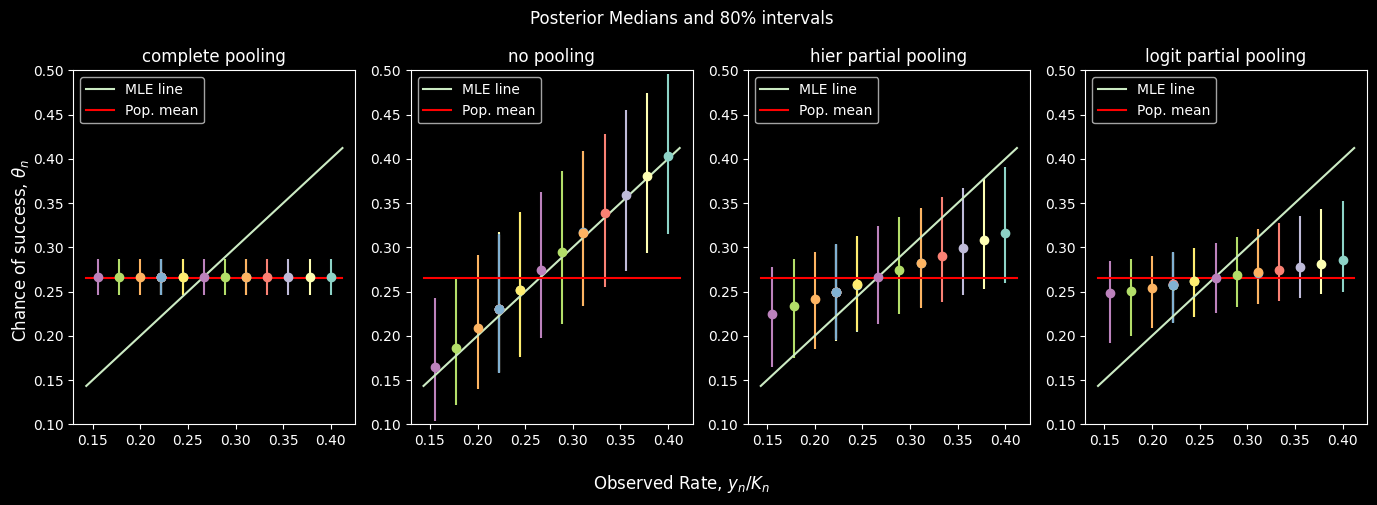

In [55]:
fig, axes = plt.subplots(1, 4, figsize=(14,5))
for ax, fit, m_name in zip(axes, model_fits, model_names):
    plot_median_interval(ax, fit, m_name, hits/at_bats, ylim=[.1, .5])
fig.suptitle('Posterior Medians and 80% intervals');
fig.supxlabel('Observed Rate, $y_n / K_n$')
fig.supylabel('Chance of success, $\\theta_n$');
fig.tight_layout()

In [56]:
# data during the season, not used in the inference
season_hits / season_at_bats

array([0.35194175, 0.30573248, 0.28268551, 0.2375    , 0.27645788,
       0.2739726 , 0.26624406, 0.22404372, 0.26666667, 0.23265306,
       0.26072041, 0.22510823, 0.29583333, 0.25776398, 0.32232704,
       0.27860697, 0.30242826, 0.1826087 ])

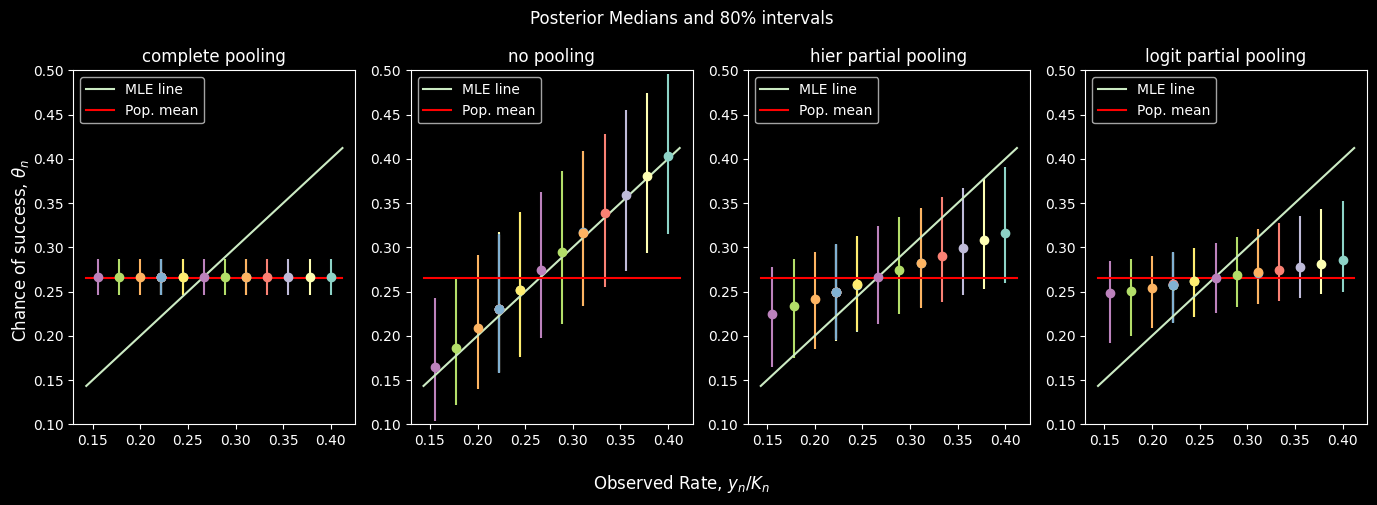

In [57]:
fig, axes = plt.subplots(1, 4, figsize=(14,5))
for ax, fit, m_name in zip(axes, model_fits, model_names):
    plot_median_interval(ax, fit, m_name, hits/at_bats, ylim=[.1, .5], 
                         season_rate=season_hits/season_at_bats)
fig.suptitle('Posterior Medians and 80% intervals');
fig.supxlabel('Observed Rate, $y_n / K_n$')
fig.supylabel('Chance of success, $\\theta_n$');
fig.tight_layout()

- The horizontal axis is the observed rate of success. The same rates are overlapped.
- The dots are the posterior medians with bars covering 80% posterior intervals.
- Players with the same observed rates are indistinguishable.
- The horizontal red line corresponds to the overall success rate,
$$
    \frac{\sum_{n=1}^N y_n}{\sum_{n=1}^N K_n} = \frac{215}{810} = 0.266
$$
    - The overall succss rat is also th posterior mode (i.e., MLE) for the complete pooling model.
- The diagonal line has intercept 0 and slope 1. Estimates falling on this line make up the MLEs for the no-pooling model.

- The choice of likelihood function and parameterization (a single parameter or one parameter per item) has a fairly large impect here on the estimated chance of success for each item.

- In the 'no-pooling' and 'complete-pooling' cases, the posterior can be calculated analytically and shown to be a beta distribution.

---
# Posterior Predictive Distribution

After we have fit a model using some training data, we are usually interested in the predictions of the fitted model for new data, which we can use to 
1. make predictions for new data points; e.g., predict how many hits will Roberto Clement get in the rest of th season
2. evaluate predictions against observed future data; e.g., how well did we prdict how many hits Clemente actually got in the rest of the season
3. generate new simulated data to validate our model fits.

With full Bayesian inference, we do not make a point estimate of parameters and use those prediction - we instead use an average of predictions weighted by the posterior.

Given data $y$ and a model with parameters $\theta \in \Theta \subset \mathbb{R}^{18}$, the posterior predictive distribution for new data $\tilde y$ is defined by

$$
        p(\tilde y | y) = \int_\Theta p(\tilde y|\theta) p(\theta|y) d\theta
$$

where $\Theta$ is the support of the parameters $\theta$.
    - The integral means that $p(\tilde y|y)$ is defined as a weighted average over the parameters $\theta\in\Theta$ of the likelihood function $p(\tilde y|\theta)$, with weights given by the posterior $p(\theta|y)$.

## Evaluating Held-Out Data Predictions
- Because the posterior predictive density is formulated as an expection over the posterior, it is possible to compute via MCMC.
- With draws $\theta^{(m)}\in\mathbb{R}^{18}$ from $p(\theta|y)$, the postrior predictive log density for a new data $y^{new}$ is given by

$$
    \log p(y^{new}| y) \approx \log \frac{1}{M} \sum_{m=1}^M p(y^{new}|\theta^{(m)})
$$

    - To prevent underflow in floating point calculations, a robust calculation on the log scale is required.

#### Simulating Replicated Data

With M draws $θ^{(m)}$ from the posterior $p(θ|y)$, replicated data can be simulated by drawing a sequence of M simulations $y^{rep(m)}$, each drawn according to distribution $p(y|θ^{(m)})$. 
- This latter random variate generation can usually be done efficiently (both computationally and statistically) by means of forward simulation from the sampling distribution; we provide an example below.

## Prediction for New Trials
Efron and Morris’s (1975) baseball data includes not only the observed hit rate in the initial 45 at bats, but also includes the data for how the player did for the rest of the season. The question arises as to how well these models predict a player’s performance for the rest of the season based on their initial 45 at bats.

After evaluating posterior predictive densities for new data, we consider how well the model actually fit the data with which it is estimated.

#### **Calibration**

A well calibrated statistical model is one in which the uncertainy in the predictions matches the uncertainty in further data. That is, if we estimate posterior 50% intervals for predictions on new data (here, number of hits in the rest of the season for each player), roughly 50% of the new data should fall in its predicted 50% interval. 
- If the model is true in the sense of correctly describing the generative process of the data, then Bayesian inference is guaranteed to be well calibrated. 
- Given that our models are rarely correct in this deep sense, in practice we are concerned with testing their calibration on quantities of interest.


#### **Sharpness**

Given two well calibrated models, the one that makes the more precise predictions in the sense of having narrower intervals is better predictively (Gneiting et al. 2007). 
- To see this in an example, we would rather have a well-calibrated prediction that there’s a 90% chance the number of hits for a player in the rest of the season will fall in (120,130) than a 90% prediction that the number of hits will fall in (100,150).

- For the models introduced here, a posterior that is a delta function provides the sharpest predictions. 
- Even so, there is residual uncertainty due to the repeated trials; with $K^{new}$ further trials and a a fixed $θ_n$ chance of success, the random variable $Y^{new}_n$ denoting the number of further successes for item $n$ has a standard deviation from the repeated binary trials of

$$
    std[Y^{new}_n] = \sqrt{ K^{new} θ_n(1−θ_n)}
$$


$$
Y_n^{new} \sim \mathrm{Binomial}(K^{new}, \theta_n)   \quad \mbox{observation model}
$$


#### Why Evaluate with the Predictive Posterior?

The predictive posterior density directly measures the probability of seeing the new data. 
- The higher the probability assigned to the new data, the better job the model has done at predicting the outcome. 
- In the limit, an ideal model would perfectly predict the new outcome with no uncertainty (probability of 1 for a discrete outcome or a delta function at the true value for the density in a continuous outcome). 
- This notion is related to the notion of sharpness discussed in the previous section, because if the new observations have higher predictive densities, they’re probably within narrower posterior intervals (Gneiting et al. 2007).

#### Calculating posterior log density
- computing the log likelihood of held-out observations using the posterior distribution $p(\theta|y)$
- this is used to evaluate the goodness-of-fit of the model
    - high log-likelihood for held-out data means the model has a high power of prediction.
    
\begin{align}
    \log p(y^{new}| y) 
        &\approx \log \frac{1}{M} \sum_{m=1}^M p(y^{new}|\theta^{(m)}) \\
        &=-\log M + \log\sum_m\exp \log p(y^{new}|\theta^{(m)})
\end{align}

$$
    p(y^{new}|K^{new}, \theta^{(m)}) = \mathrm{Binomial}(y^{new}|K^{new}, \theta_n)
$$

1. compute: $u_m = \log p(y^{new}|\theta^{(m)})$ 


2. $u^* = \max u_m$ 

\begin{align}
    \log\sum_m\exp(u_m) 
        &= \log\bigg\{ {exp(u^*)}\sum_m\exp(u_m - u^*) \bigg\}  \\
        &= u^* + \log\bigg\{ \sum_m\exp(u_m - u^*) \bigg\}  
\end{align}

In [58]:
# jax does not have this function. Very silly.
def log_binomial(k, n, p):
    import scipy
    bl = scipy.stats.binom.logpmf(k, n, p)
    return bl

In [59]:
log_binomial(season_hits, season_at_bats, [.5]*18)

array([-21.52790552, -39.72630362, -58.57523301, -49.33906637,
       -51.13699572, -57.38458582, -75.04612132, -32.14492397,
       -66.10684994, -39.72743008, -72.85454053, -39.69399197,
       -44.4324134 , -42.40676256, -44.43132022, -64.53133666,
       -39.54800835, -27.39392265])

In [60]:
log_binomial(season_hits, season_at_bats, np.array([[.5]*18, [.1]*18]))

array([[ -21.52790552,  -39.72630362,  -58.57523301,  -49.33906637,
         -51.13699572,  -57.38458582,  -75.04612132,  -32.14492397,
         -66.10684994,  -39.72743008,  -72.85454053,  -39.69399197,
         -44.4324134 ,  -42.40676256,  -44.43132022,  -64.53133666,
         -39.54800835,  -27.39392265],
       [ -97.95736329,  -79.27912359,  -77.44391305,  -28.23640148,
         -60.23651576,  -64.63704088,  -73.28646476,  -14.66617196,
         -65.07448837,  -20.96149808,  -64.15305064,  -18.1709504 ,
         -74.30070423,  -35.50909638, -121.0300397 ,  -79.22970672,
         -74.30041624,   -5.94017231]])

In [61]:
# naive computation
s = mcmcfit_logit_nc.get_samples()
print(s.keys())
theta = s['theta']
M = s['theta'].shape[0]
log_p_new = log_binomial(season_hits, season_at_bats, s['theta'])
log_p_new.shape, M

dict_keys(['alpha', 'alpha_std', 'mu', 'sigma', 'theta'])


((10000, 18), 10000)

In [62]:
season_hits / season_at_bats

array([0.35194175, 0.30573248, 0.28268551, 0.2375    , 0.27645788,
       0.2739726 , 0.26624406, 0.22404372, 0.26666667, 0.23265306,
       0.26072041, 0.22510823, 0.29583333, 0.25776398, 0.32232704,
       0.27860697, 0.30242826, 0.1826087 ])

binomial distribution:

$$
    \mathrm{pmf}(k| n, p) = \frac{n!}{k! (n-k)!} p^k (1-p)^k,\quad k=0,...,n
$$

---

In [63]:
u = log_binomial(season_hits, season_at_bats, s['theta'])
u.shape, u[:2,:4]

((10000, 18),
 array([[-12.17326005,  -7.11183649,  -4.34083106,  -3.1550312 ],
        [ -3.56526586,  -4.36228953,  -3.53392497,  -6.93588193]]))

In [64]:
lp = logsumexp(u, axis=0) - jnp.log(10000)
lp

DeviceArray([-4.936754 , -4.174875 , -4.021736 , -3.889876 , -3.7790585,
             -3.8447862, -3.9784698, -3.4176016, -3.87507  , -3.4628572,
             -3.9188333, -3.4812136, -4.40173  , -3.438529 , -5.849996 ,
             -4.216784 , -4.804186 , -3.3925104], dtype=float32)

In [65]:
lp.sum()  # posterior log likelihood

DeviceArray(-72.88486, dtype=float32)

---

In [66]:
# using a numpyro function
from numpyro.infer import log_likelihood
#
post_loglik = log_likelihood(logit_model_non_centered, 
                             mcmcfit_logit_nc.get_samples(),
                             season_at_bats, season_hits
                             )['y']
post_loglik.shape, post_loglik[:2, :4]

((10000, 18),
 DeviceArray([[-12.173218 ,  -7.1118164,  -4.3410645,  -3.1549072],
              [ -3.5653076,  -4.3623047,  -3.5341797,  -6.935791 ]],            dtype=float32))

In [67]:
log_p = logsumexp(post_loglik, axis=0) - jnp.log(jnp.shape(post_loglik)[0])
log_p

DeviceArray([-4.9367824, -4.175044 , -4.0219574, -3.8897667, -3.7791681,
             -3.8449326, -3.978385 , -3.4175014, -3.875062 , -3.4628592,
             -3.9190989, -3.481429 , -4.4016438, -3.4389048, -5.8496423,
             -4.216917 , -4.8040957, -3.39252  ], dtype=float32)

In [68]:
log_p.sum()

DeviceArray(-72.885704, dtype=float32)

In [69]:
jnp.shape(post_loglik)

(10000, 18)

---
## Predicting New Observations

In [70]:
from numpyro.infer import Predictive

In [71]:
models = [cp_model, np_model, pp_model, logit_model_non_centered]
model_fits = [mcmcfit_cp, mcmcfit_np, mcmcfit_hier, mcmcfit_logit_nc]
model_names = ['complete pooling', 'no pooling', 'hier partial pooling', 'logit partial pooling']

In [72]:
# let's try Predictive with a model
predictive = Predictive(np_model, posterior_samples=mcmcfit_np.get_samples())
# then we can run posterior sampling
predict = predictive(jax.random.PRNGKey(0), season_at_bats)
predict, predict['y'].shape

({'y': DeviceArray([[138, 163, 280, ...,  85,  53,  22],
               [197, 212, 150, ..., 177, 112,  16],
               [120, 151, 253, ...,  92,  47,  17],
               ...,
               [188, 147, 231, ..., 113,  50,  15],
               [144, 235, 212, ..., 196, 115,  22],
               [164, 134, 177, ..., 124,  90,  16]], dtype=int32)},
 (10000, 18))

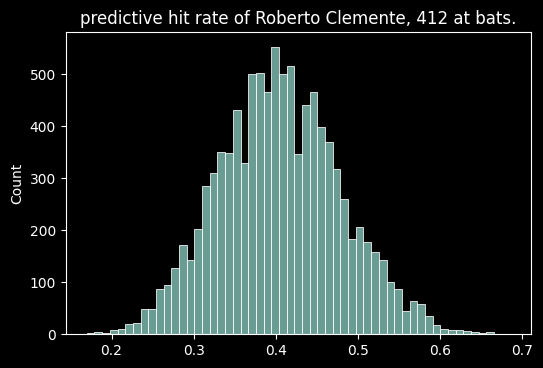

In [73]:
# The first playr's predicted hit rate, distribution with samples
hr = predict['y'][:,0] / season_at_bats[0]
ax = sns.histplot(hr);
ax.set(title=f'predictive hit rate of {player_names[0]}, {season_at_bats[0]} at bats.');

In [74]:
hit_rates = predict['y'] / season_at_bats
hit_rates, hit_rates.shape

(DeviceArray([[0.33495146, 0.3460722 , 0.49469966, ..., 0.14096186,
               0.11699779, 0.19130434],
              [0.47815534, 0.45010614, 0.26501766, ..., 0.29353234,
               0.24724062, 0.13913043],
              [0.29126215, 0.3205945 , 0.44699648, ..., 0.15257049,
               0.10375276, 0.14782609],
              ...,
              [0.4563107 , 0.3121019 , 0.40812722, ..., 0.18739635,
               0.11037528, 0.13043478],
              [0.34951457, 0.49893844, 0.3745583 , ..., 0.32504147,
               0.25386313, 0.19130434],
              [0.39805827, 0.28450108, 0.31272084, ..., 0.20563847,
               0.1986755 , 0.13913043]], dtype=float32),
 (10000, 18))

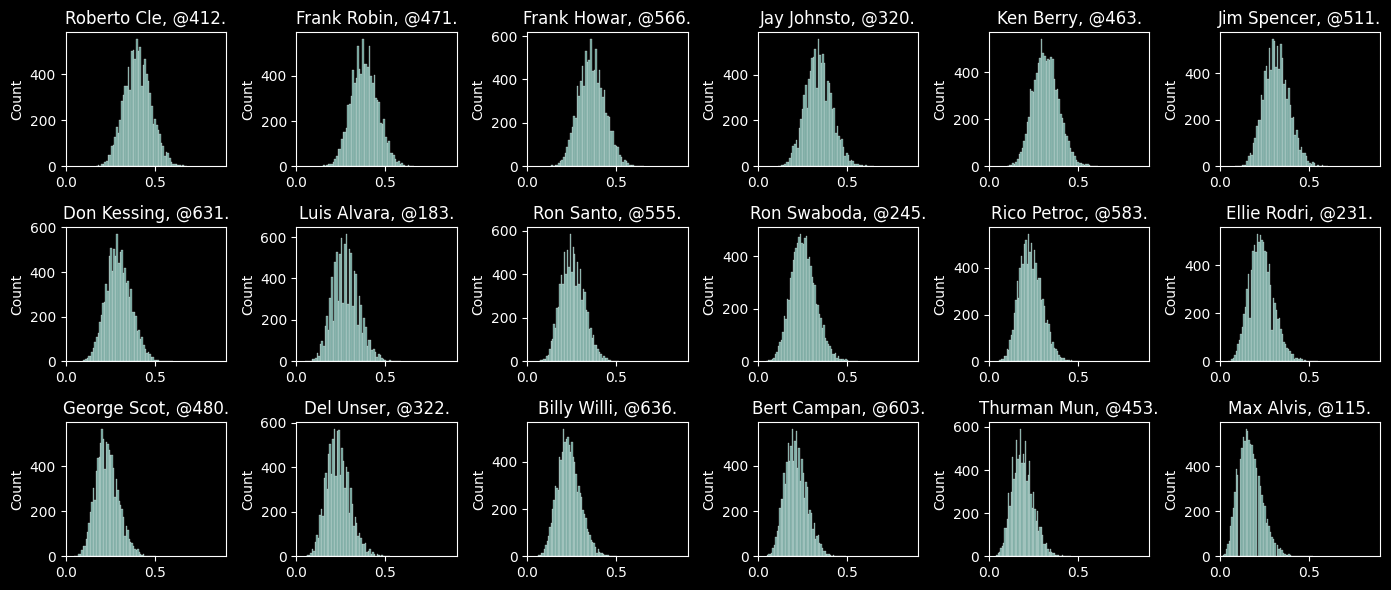

In [75]:
fig, axes = plt.subplots(3, 6, figsize=(14, 6))
for hr, ax, pname, sab in zip(hit_rates.T, axes.ravel(), player_names, season_at_bats):
    sns.histplot(hr, ax=ax)
    ax.set(xlim=[0,.9], title=f'{pname[:11]}, @{sab}.')
fig.tight_layout()

End.

---

In [76]:
!jupyter nbconvert bball_1970.ipynb --to webpdf --HTMLExporter.theme=dark --allow-chromium-download

[NbConvertApp] Converting notebook bball_1970.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 889136 bytes to bball_1970.pdf
